# Basics of Gaussian Processes with george

*This notebook first appeared as a [blog post](//betatim.github.io/posts/gaussian-processes-with-george) on [Tim Head](//betatim.github.io)'s blog.*

*License: [MIT](http://opensource.org/licenses/MIT)*

*(C) 2015, Tim Head.*
*Feel free to use, distribute, and modify with the above attribution.*

Gaussian process regression is one of the techniques used by [Bayesian optimisation](https://en.wikipedia.org/wiki/Bayesian_optimization) to find the best hyperparameters of a machine learning algorithms and other optimisation problems with very expensive cost functions.

Rasmussen and Williams have written a very [good introduction to Gaussian processes](http://www.gaussianprocess.org/gpml/chapters/) in general.

This blog post is about the absolute basics of understanding gaussian processes and how to use them via a nice python package called [`george`](http://dan.iel.fm/george/current/).

The problem we would like to solve is: how do I model a complicated function if evaluating it is very expensive? For example:

* you want to find the right mixture of ingredients to maximise the efficiency of a new drug, but testing each new mixture takes days (or months)
* you want to optimise the layout of a particle physics detector, but simulating each new layout takes months of CPU time
* you want to find the optimal hyperparameters for your machine learning model, but training and evaluating a new model takes days of CPU time

The technical term for this is gaussian process regression. Let's get going!

In [1]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import george
from george.kernels import ExpSquaredKernel

For an example we always have a slight advantage as we have to choose the function that we are trying to discover. The reason we are at an advantage is that normally we do not know this function.

Let's choose $y\left( x \right) = -x \sin(x)$ in the range $0 < x < 10$.

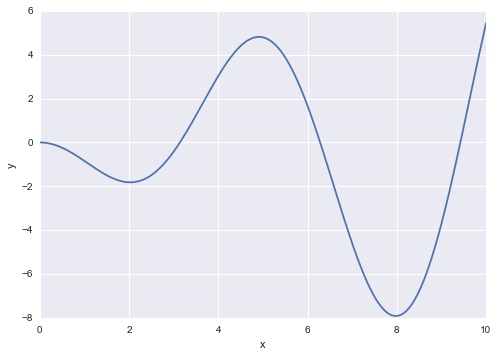

In [6]:
xsinx = lambda x: -x*np.sin(x)

t = np.linspace(0, 10, 500)

plt.plot(t, xsinx(t))
plt.ylabel("y")
plt.xlabel("x")

Let's sample ten points at random $x$ values in one go (even if we won't use them all at one). We also add some gaussian noise to each point.

In [7]:
# Generate some fake, noisy data
x = 10 * np.sort(np.random.rand(10))
yerr = 0.2 * np.ones_like(x)
y = xsinx(x) + yerr * np.random.randn(len(x))

The main ingredient of a gaussian process is the kernel. It describes how correlated each point is with every other.

In [11]:
# Set up a Gaussian process
kernel = ExpSquaredKernel(1.0)
gp = george.GP(kernel)

## Zero Knowledge

What kind of functions to you get from this gaussian process before you give it any data? You can sample from them using the `sample()` method. Below ten examples.

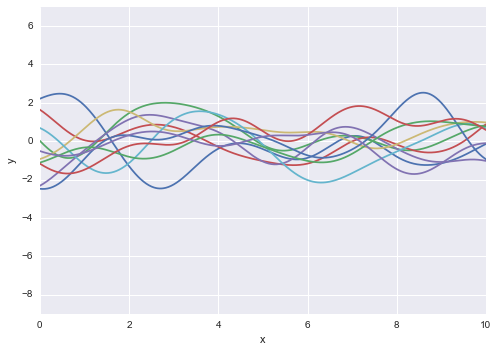

In [25]:
def label_and_limits(axis):
    ax.set_ylim(-9,7)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

fig, ax = plt.subplots()

for pred in gp.sample(t, 10):
    ax.plot(t, pred)

label_and_limits(ax)

If we choose a different kernel, the functions we sample will end up looking different.

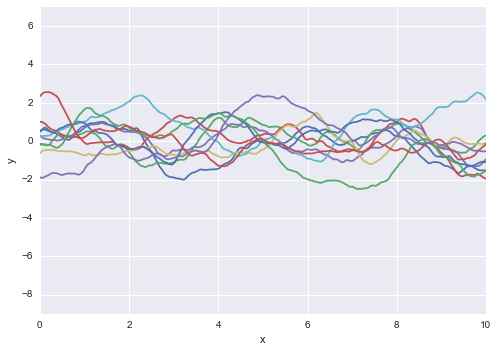

In [26]:
from george.kernels import Matern32Kernel

matern_kernel = Matern32Kernel(1.0)
matern_gp = george.GP(matern_kernel)

fig, ax = plt.subplots()

for pred in matern_gp.sample(t, 10):
    ax.plot(t, pred)

label_and_limits(ax)

## Adding Knowledge

So far so boring. Let's add the first four our data points to the gaussian process and see what kind of functions we now sample. By adding points we narrow down the space from which we can sample functions. As you can see all the sampled functions go close to the data points we added.

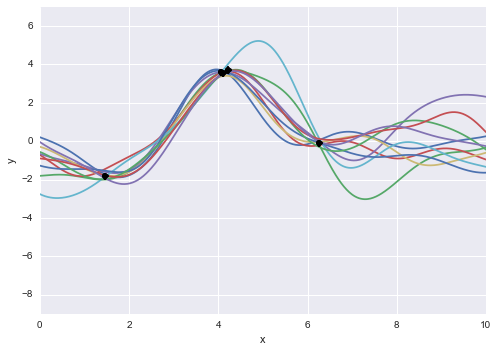

In [27]:
Nmax = 5

gp.compute(x[:Nmax], yerr[:Nmax])

fig, ax = plt.subplots()

for pred in gp.sample_conditional(y[:Nmax], t, 10):
    ax.plot(t, pred)

ax.errorbar(x[:Nmax], y[:Nmax], yerr=yerr[:Nmax], fmt='ok', zorder=3)
label_and_limits(ax)

If we add one more point the range of possible functions, the range narrows even more:

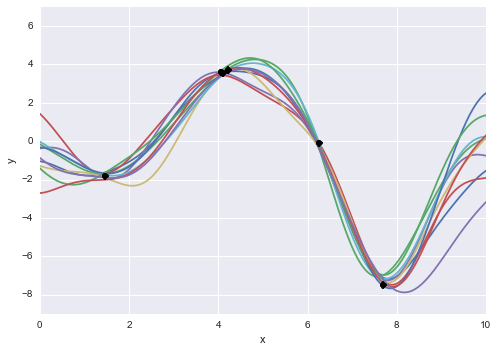

In [28]:
Nmax = 6

gp.compute(x[:Nmax], yerr[:Nmax])

fig, ax = plt.subplots()

for pred in gp.sample_conditional(y[:Nmax], t, 10):
    ax.plot(t, pred)

ax.errorbar(x[:Nmax], y[:Nmax], yerr=yerr[:Nmax], fmt='ok', zorder=3)
label_and_limits(ax)

## All Together Now

Adding all our points reduces the space of possible functions even further. Here we plot the median predicted value and the one sigma band around it. You could get a similar effect by sampling several functions and plotting them with some transparency. In green the original function from which we sampled. Does not look to bad does it?

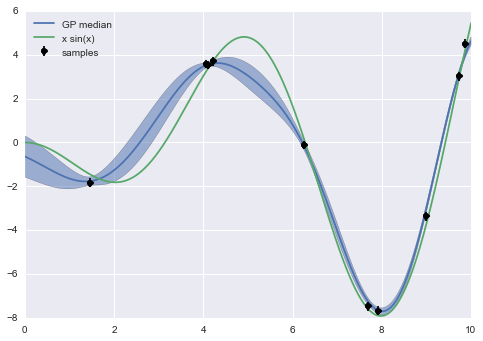

In [35]:
gp.compute(x, yerr)

mu, cov = gp.predict(y, t)
std = np.sqrt(np.diag(cov))

fig, ax = plt.subplots()

ax.plot(t, mu, label="GP median")
ax.plot(t, xsinx(t), label="x sin(x)")
ax.fill_between(t, mu-std, mu+std, alpha=0.5)
# explicit zorder to draw points and errorbars on top of everything
ax.errorbar(x, y, yerr=yerr, fmt='ok', zorder=3, label="samples")
ax.legend(loc='best')

## Wrapping it up

To bring it back to optimising a cost function while sampling it only a few times. A gaussian process provides you with its best guess and an uncertainty for every point of your function. At the beginning the guess is not very good, it repeats back at you what you put in as the prior for the possible functions. As you add more data however you get a better and better estimate. All without having to make any assumptions about the shape of the function you are looking for.

This is interesting for expensive functions as you can use your current knowledge to estimate where the minimum/maximum is, sample a further point at that location, and so focus your expensive sampling on locations which are promising in terms of being the best point.

If you find a mistake or want to tell me something else get in touch on twitter @[betatim](//twitter.com/betatim)